# LOAD DATA

# MODEL ARCHITECTURE AND TRAIN MODEL

TensorFlow version: 2.10.0
Num GPUs Available:  1
Training data shape: (7730, 64, 64, 3)
Validation data shape: (1934, 64, 64, 3)
Test data shape: (2416, 64, 64, 3)
Training labels shape: (7730, 2)
Validation labels shape: (1934, 2)
Test labels shape: (2416, 2)


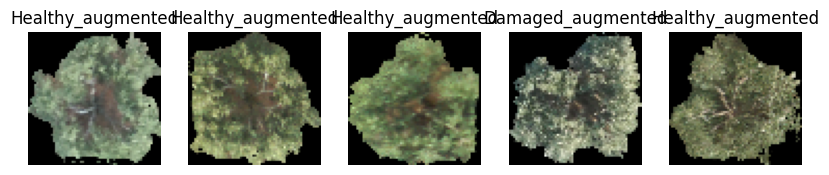

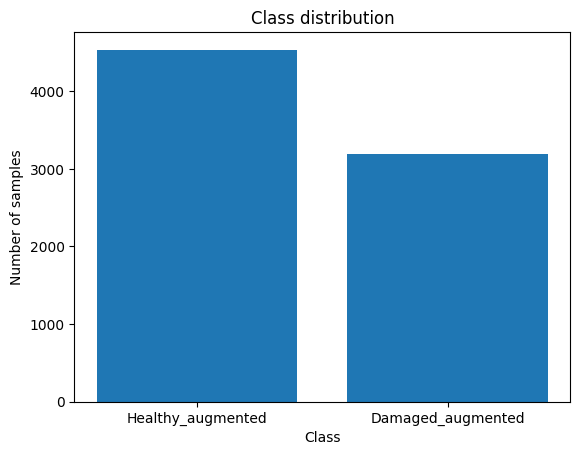

Epoch 1/50
241/241 [==============================] - 22s 82ms/step - loss: 0.9499 - accuracy: 0.5257 - val_loss: 0.7521 - val_accuracy: 0.3981 - lr: 1.0000e-04
Epoch 2/50
241/241 [==============================] - 19s 78ms/step - loss: 0.8104 - accuracy: 0.5305 - val_loss: 0.6499 - val_accuracy: 0.6174 - lr: 1.0000e-04
Epoch 3/50
241/241 [==============================] - 19s 79ms/step - loss: 0.7580 - accuracy: 0.5383 - val_loss: 0.8215 - val_accuracy: 0.4752 - lr: 1.0000e-04
Epoch 4/50
241/241 [==============================] - 19s 78ms/step - loss: 0.7324 - accuracy: 0.5446 - val_loss: 0.7895 - val_accuracy: 0.4602 - lr: 1.0000e-04
Epoch 5/50
241/241 [==============================] - 19s 79ms/step - loss: 0.7171 - accuracy: 0.5585 - val_loss: 0.7131 - val_accuracy: 0.5372 - lr: 1.0000e-04
Epoch 6/50
241/241 [==============================] - 19s 78ms/step - loss: 0.7038 - accuracy: 0.5630 - val_loss: 0.7350 - val_accuracy: 0.5114 - lr: 1.0000e-04
Epoch 7/50
241/241 [==============

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Verify GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

base_dir = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\data_aug_3'
subfolders = ['clear', 'clouds']
categories = ['Healthy_augmented', 'Damaged_augmented']
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

def load_data(base_dir, subfolders, categories, img_height, img_width):
    data = []
    labels = []
    image_paths = []
    for category in categories:
        class_num = categories.index(category)
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder, category)
            images = sorted(os.listdir(folder_path))
            for img_name in images:
                if img_name.endswith('.png'):
                    img_path = os.path.join(folder_path, img_name)
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(class_num)
                    image_paths.append((subfolder, category, img_name))
    return np.array(data), np.array(labels), image_paths

data, labels, image_paths = load_data(base_dir, subfolders, categories, IMG_HEIGHT, IMG_WIDTH)
data = data / 255.0

# Split data ensuring twins are in the same split
def split_data(image_paths):
    unique_image_ids = list(set([img_name for subfolder, category, img_name in image_paths]))
    train_ids, test_ids = train_test_split(unique_image_ids, test_size=0.2, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    return train_ids, val_ids, test_ids

def get_split_indices(image_paths, split_ids):
    split_indices = [i for i, (subfolder, category, img_name) in enumerate(image_paths) if img_name in split_ids]
    return split_indices

train_ids, val_ids, test_ids = split_data(image_paths)
train_indices = get_split_indices(image_paths, train_ids)
val_indices = get_split_indices(image_paths, val_ids)
test_indices = get_split_indices(image_paths, test_ids)

X_train, y_train = data[train_indices], labels[train_indices]
X_val, y_val = data[val_indices], labels[val_indices]
X_test, y_test = data[test_indices], labels[test_indices]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

# Visualize some training samples
def visualize_samples(data, labels, categories, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = random.randint(0, len(data) - 1)
        plt.subplot(5, 5, i + 1)
        plt.imshow(data[idx])
        plt.title(categories[np.argmax(labels[idx])])
        plt.axis('off')
    plt.show()

visualize_samples(X_train, y_train, categories)

# Check class distribution
def plot_class_distribution(labels, categories):
    class_counts = np.sum(labels, axis=0)
    plt.bar(categories, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.show()

plot_class_distribution(y_train, categories)

# Define data augmentation
def create_datagen():
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Corrected residual block
def residual_block(x, filters, kernel_size):
    shortcut = x
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Modified model architecture
def build_complex_model(input_shape):
    inputs = Input(shape=(input_shape[1], input_shape[2], input_shape[3]))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    for _ in range(3):
        x = residual_block(x, 64, 3)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_complex_model(X_train.shape)

datagen = create_datagen()
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr, early_stopping],
        class_weight=class_weights,
        verbose=1
    )

# Save the final model to a local directory
final_model_save_path = 'best_model_final.h5'
model.save(final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

# Make predictions on the test set
with tf.device('/GPU:0'):
    test_predictions = model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(test_predictions, axis=1)

# Generate the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):")
print(test_conf_matrix)

# Generate the classification report for the test set
test_class_report = classification_report(y_test_true, y_test_pred, target_names=categories)
print("Classification Report (Test):")
print(test_class_report)


TensorFlow version: 2.10.0
Num GPUs Available:  1
Training data shape: (7248, 64, 64, 3)
Validation data shape: (2416, 64, 64, 3)
Test data shape: (2416, 64, 64, 3)
Training labels shape: (7248, 2)
Validation labels shape: (2416, 2)
Test labels shape: (2416, 2)


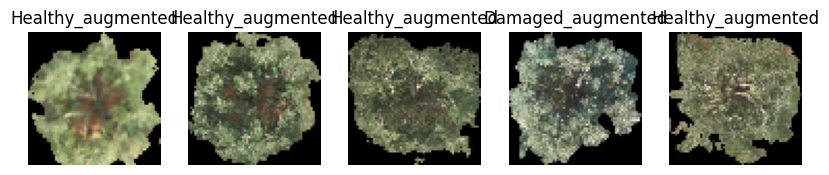

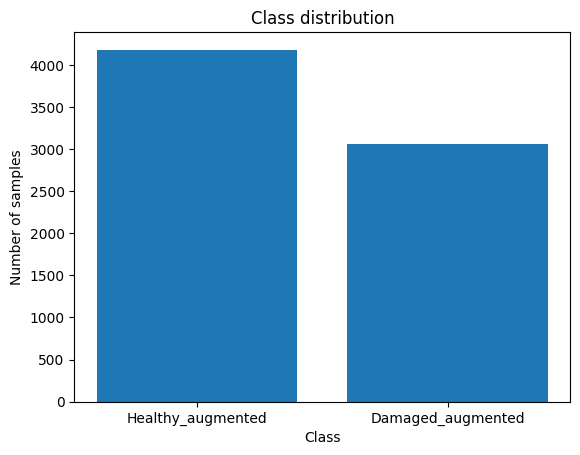

Class weights: {0: 0.8661567877629063, 1: 1.1827676240208878}

Combination 1/50: num_residual_blocks=4, dropout_rate=0.5, filters=128, kernel_size=1, num_dense_layers=1, activation_function=tanh, learning_rate=0.001
Epoch 1/50
226/226 [==============================] - 32s 127ms/step - loss: 0.9842 - accuracy: 0.5240 - val_loss: 0.6722 - val_accuracy: 0.6113 - lr: 0.0010
Epoch 2/50
226/226 [==============================] - 28s 125ms/step - loss: 0.8071 - accuracy: 0.5291 - val_loss: 0.7123 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 3/50
226/226 [==============================] - 28s 126ms/step - loss: 0.7748 - accuracy: 0.5341 - val_loss: 0.6675 - val_accuracy: 0.6084 - lr: 0.0010
Epoch 4/50
226/226 [==============================] - 28s 125ms/step - loss: 0.7647 - accuracy: 0.5409 - val_loss: 0.6609 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 5/50
226/226 [==============================] - 28s 125ms/step - loss: 0.7657 - accuracy: 0.5435 - val_loss: 0.7956 - val_accuracy: 0.6068 - lr: 0

KeyboardInterrupt: 

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from itertools import product
import random 

# Verify GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

base_dir = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\data_aug_3'
subfolders = ['clear', 'clouds']
categories = ['Healthy_augmented', 'Damaged_augmented']
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32

def load_data(base_dir, subfolders, categories, img_height, img_width):
    data = []
    labels = []
    image_paths = []
    for category in categories:
        class_num = categories.index(category)
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder, category)
            images = sorted(os.listdir(folder_path))
            for img_name in images:
                if img_name.endswith('.png'):
                    img_path = os.path.join(folder_path, img_name)
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(class_num)
                    image_paths.append((subfolder, category, img_name))
    return np.array(data), np.array(labels), image_paths

data, labels, image_paths = load_data(base_dir, subfolders, categories, IMG_HEIGHT, IMG_WIDTH)
data = data / 255.0

# Split data ensuring twins are in the same split
def split_data(image_paths):
    unique_image_ids = list(set([img_name for subfolder, category, img_name in image_paths]))
    train_ids, test_ids = train_test_split(unique_image_ids, test_size=0.2, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    return train_ids, val_ids, test_ids

def get_split_indices(image_paths, split_ids):
    split_indices = [i for i, (subfolder, category, img_name) in enumerate(image_paths) if img_name in split_ids]
    return split_indices

train_ids, val_ids, test_ids = split_data(image_paths)
train_indices = get_split_indices(image_paths, train_ids)
val_indices = get_split_indices(image_paths, val_ids)
test_indices = get_split_indices(image_paths, test_ids)

X_train, y_train = data[train_indices], labels[train_indices]
X_val, y_val = data[val_indices], labels[val_indices]
X_test, y_test = data[test_indices], labels[test_indices]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

# # Visualize some training samples
# def visualize_samples(data, labels, categories, num_samples=5):
#     plt.figure(figsize=(10, 10))
#     for i in range(num_samples):
#         idx = random.randint(0, len(data) - 1)
#         plt.subplot(5, 5, i + 1)
#         plt.imshow(data[idx])
#         plt.title(categories[np.argmax(labels[idx])])
#         plt.axis('off')
#     plt.show()

# visualize_samples(X_train, y_train, categories)

# Check class distribution
def plot_class_distribution(labels, categories):
    class_counts = np.sum(labels, axis=0)
    plt.bar(categories, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.show()

plot_class_distribution(y_train, categories)

# Define data augmentation
def create_datagen():
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Corrected residual block
def residual_block(x, filters, kernel_size):
    shortcut = x
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Modified model architecture
def build_complex_model(input_shape, num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate):
    inputs = Input(shape=(input_shape[1], input_shape[2], input_shape[3]))
    x = Conv2D(32, (3, 3), activation=activation_function, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    for _ in range(num_dense_layers):
        x = Dense(2048, activation=activation_function)(x)
        x = Dropout(dropout_rate)(x)
        x = BatchNormalization()(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter tuning parameters (only architecture and training-related)
num_residual_blocks_options = [2, 3, 4]
dropout_rate_options = [0.3, 0.4, 0.5]
filters_options = [64, 128, 256]
kernel_size_options = [1, 3, 5]
num_dense_layers_options = [1, 2]
activation_function_options = ['relu', 'tanh']
learning_rate_options = [1e-3, 5e-4, 1e-4]

# Create grid search parameter combinations
parameter_combinations = list(product(num_residual_blocks_options, dropout_rate_options, filters_options, kernel_size_options, num_dense_layers_options, activation_function_options, learning_rate_options))

# Ensure unique combinations by pairing each architecture with all possible training hyperparameters
parameter_combinations = random.sample(parameter_combinations, 50)

# Compute class weights using the training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Perform exhaustive search for hyperparameter tuning
best_val_accuracy = 0
best_params = None
best_model_save_path = 'best_model_tuning.h5'

for idx, (num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate) in enumerate(parameter_combinations):
    print(f"\nCombination {idx + 1}/{len(parameter_combinations)}: num_residual_blocks={num_residual_blocks}, dropout_rate={dropout_rate}, filters={filters}, kernel_size={kernel_size}, num_dense_layers={num_dense_layers}, activation_function={activation_function}, learning_rate={learning_rate}")
    
    datagen = create_datagen()
    datagen.fit(X_train)
    train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
    
    model = build_complex_model(X_train.shape, num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate)
    
    with tf.device('/GPU:0'):
        history = model.fit(
            train_generator,
            steps_per_epoch=len(X_train) // BATCH_SIZE,
            epochs=50,
            validation_data=(X_val, y_val),
            callbacks=[reduce_lr, early_stopping],
            class_weight=class_weights,
            verbose=1
        )
    
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation accuracy: {val_accuracy}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = (num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate)
        model.save(best_model_save_path)
        print(f"Model with validation accuracy {val_accuracy} saved to {best_model_save_path}")

print(f"\nBest parameters found: num_residual_blocks={best_params[0]}, dropout_rate={best_params[1]}, filters={best_params[2]}, kernel_size={best_params[3]}, num_dense_layers={best_params[4]}, activation_function={best_params[5]}, learning_rate={best_params[6]}")
print(f"Best validation accuracy: {best_val_accuracy}")

# Load the best model from the hyperparameter tuning phase
best_model = tf.keras.models.load_model(best_model_save_path)

# Combine training and validation sets for final training
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Compute class weights using the combined training and validation set
class_weights_train_val = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train_val, axis=1)), y=np.argmax(y_train_val, axis=1))
class_weights_train_val = dict(enumerate(class_weights_train_val))

print(f"Class weights (train + val): {class_weights_train_val}")

# Create data generator for the combined training and validation set
datagen_train_val = create_datagen()
datagen_train_val.fit(X_train_val)
train_val_generator = datagen_train_val.flow(X_train_val, y_train_val, batch_size=BATCH_SIZE)

# Train the best model on the combined training and validation set
with tf.device('/GPU:0'):
    final_history = best_model.fit(
        train_val_generator,
        steps_per_epoch=len(X_train_val) // BATCH_SIZE,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr, early_stopping],
        class_weight=class_weights_train_val,
        verbose=1
    )

# Save the final model to a local directory
final_model_save_path = 'best_model_final.h5'
best_model.save(final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

# Make predictions on the test set
with tf.device('/GPU:0'):
    test_predictions = best_model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(test_predictions, axis=1)

# Generate the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):")
print(test_conf_matrix)

# Generate the classification report for the test set
test_class_report = classification_report(y_test_true, y_test_pred, target_names=categories)
print("Classification Report (Test):")
print(test_class_report)

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from itertools import product

# Verify GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

base_dir = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\data_aug_3'
subfolders = ['clear', 'clouds']
categories = ['Healthy_augmented', 'Damaged_augmented']
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 8

def load_data(base_dir, subfolders, categories, img_height, img_width):
    data = []
    labels = []
    image_paths = []
    for category in categories:
        class_num = categories.index(category)
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder, category)
            images = sorted(os.listdir(folder_path))
            for img_name in images:
                if img_name.endswith('.png'):
                    img_path = os.path.join(folder_path, img_name)
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(class_num)
                    image_paths.append((subfolder, category, img_name))
    return np.array(data), np.array(labels), image_paths

data, labels, image_paths = load_data(base_dir, subfolders, categories, IMG_HEIGHT, IMG_WIDTH)
data = data / 255.0

# Split data ensuring twins are in the same split
def split_data(image_paths):
    unique_image_ids = list(set([img_name for subfolder, category, img_name in image_paths]))
    train_ids, test_ids = train_test_split(unique_image_ids, test_size=0.2, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    return train_ids, val_ids, test_ids

def get_split_indices(image_paths, split_ids):
    split_indices = [i for i, (subfolder, category, img_name) in enumerate(image_paths) if img_name in split_ids]
    return split_indices

train_ids, val_ids, test_ids = split_data(image_paths)
train_indices = get_split_indices(image_paths, train_ids)
val_indices = get_split_indices(image_paths, val_ids)
test_indices = get_split_indices(image_paths, test_ids)

X_train, y_train = data[train_indices], labels[train_indices]
X_val, y_val = data[val_indices], labels[val_indices]
X_test, y_test = data[test_indices], labels[test_indices]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

# Define data augmentation
def create_datagen():
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

def residual_block(x, filters, kernel_size):
    shortcut = x
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('tanh')(x)
    return x

def build_complex_model(input_shape, num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate):
    combined_input = Input(shape=(input_shape[1], input_shape[2], input_shape[3]), name='combined_input')
    
    x = Conv2D(filters, (kernel_size, kernel_size), activation=activation_function, padding='same')(combined_input)
    x = MaxPooling2D((2, 2))(x)
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size)
        if x.shape[1] >= 2 and x.shape[2] >= 2:
            x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    
    for _ in range(num_dense_layers):
        x = Dense(2048, activation=activation_function)(x)
        x = Dropout(dropout_rate)(x)
        x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=combined_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = X_train.shape

# Hyperparameter tuning parameters (only architecture and training-related)
num_residual_blocks_options = [1, 2, 3, 4]
dropout_rate_options = [0.3, 0.4, 0.5]
filters_options = [64, 128, 256]
kernel_size_options = [1, 3, 5]
num_dense_layers_options = [1, 2, 3]
activation_function_options = ['relu', 'tanh']
learning_rate_options = [1e-2, 1e-3, 1e-4]

# Create grid search parameter combinations
parameter_combinations = list(product(num_residual_blocks_options, dropout_rate_options, filters_options, kernel_size_options, num_dense_layers_options, activation_function_options, learning_rate_options))

# Compute class weights using the training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

print(f"Class weights: {class_weights}")

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Perform exhaustive search for hyperparameter tuning
best_val_accuracy = 0
best_params = None
best_model_save_path = 'best_model_tuning.h5'

for idx, (num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate) in enumerate(parameter_combinations):
    print(f"\nCombination {idx + 1}/{len(parameter_combinations)}: num_residual_blocks={num_residual_blocks}, dropout_rate={dropout_rate}, filters={filters}, kernel_size={kernel_size}, num_dense_layers={num_dense_layers}, activation_function={activation_function}, learning_rate={learning_rate}")
    
    datagen = create_datagen()
    datagen.fit(X_train)
    train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
    
    model = build_complex_model(input_shape, num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate)
    
    with tf.device('/GPU:0'):
        history = model.fit(
            train_generator,
            steps_per_epoch=len(X_train) // BATCH_SIZE,
            epochs=50,
            validation_data=(X_val, y_val),
            callbacks=[reduce_lr, early_stopping],
            class_weight=class_weights,
            verbose=1
        )
    
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation accuracy: {val_accuracy}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = (num_residual_blocks, dropout_rate, filters, kernel_size, num_dense_layers, activation_function, learning_rate)
        model.save(best_model_save_path)
        print(f"Model with validation accuracy {val_accuracy} saved to {best_model_save_path}")

print(f"\nBest parameters found: num_residual_blocks={best_params[0]}, dropout_rate={best_params[1]}, filters={best_params[2]}, kernel_size={best_params[3]}, num_dense_layers={best_params[4]}, activation_function={best_params[5]}, learning_rate={best_params[6]}")
print(f"Best validation accuracy: {best_val_accuracy}")

# Load the best model from the hyperparameter tuning phase
best_model = tf.keras.models.load_model(best_model_save_path)

# Combine training and validation sets for final training
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Compute class weights using the combined training and validation set
class_weights_train_val = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train_val, axis=1)), y=np.argmax(y_train_val, axis=1))
class_weights_train_val = dict(enumerate(class_weights_train_val))

print(f"Class weights (train + val): {class_weights_train_val}")

# Create data generator for the combined training and validation set
datagen_train_val = create_datagen()
datagen_train_val.fit(X_train_val)
train_val_generator = datagen_train_val.flow(X_train_val, y_train_val, batch_size=BATCH_SIZE)

# Train the best model on the combined training and validation set
with tf.device('/GPU:0'):
    final_history = best_model.fit(
        train_val_generator,
        steps_per_epoch=len(X_train_val) // BATCH_SIZE,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr, early_stopping],
        class_weight=class_weights_train_val,
        verbose=1
    )

# Save the final model to a local directory
final_model_save_path = 'best_model_final.h5'
best_model.save(final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

# Make predictions on the test set
with tf.device('/GPU:0'):
    test_predictions = best_model.predict(X_test)

# Convert one-hot encoded predictions and true labels to label indices
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(test_predictions, axis=1)

# Generate the confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)

print("Confusion Matrix (Test):")
print(test_conf_matrix)

# Generate the classification report for the test set
test_class_report = classification_report(y_test_true, y_test_pred, target_names=categories)

print("Classification Report (Test):")
print(test_class_report)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Training data shape: (7248, 64, 64, 3)
Validation data shape: (2416, 64, 64, 3)
Test data shape: (2416, 64, 64, 3)
Training labels shape: (7248, 2)
Validation labels shape: (2416, 2)
Test labels shape: (2416, 2)
Class weights: {0: 0.8636796949475691, 1: 1.1874180865006554}

Combination 1/1944: num_residual_blocks=1, dropout_rate=0.3, filters=64, kernel_size=1, num_dense_layers=1, activation_function=relu, learning_rate=0.01
Epoch 1/50
906/906 [==============================] - 17s 16ms/step - loss: 1.4881 - accuracy: 0.4956 - val_loss: 0.6793 - val_accuracy: 0.5869 - lr: 0.0100
Epoch 2/50
906/906 [==============================] - 14s 15ms/step - loss: 0.8808 - accuracy: 0.5156 - val_loss: 0.8895 - val_accuracy: 0.4197 - lr: 0.0100
Epoch 3/50
906/906 [==============================] - 14s 16ms/step - loss: 0.7550 - accuracy: 0.5152 - val_loss: 0.6832 - val_accuracy: 0.5803 - lr: 0.0100
Epoch 4/50
906/906 [==============================]

KeyboardInterrupt: 